<a href="https://colab.research.google.com/github/asrenninger/urbansim/blob/main/miscellany/ario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling the Role of Inventories and Heterogeneity in the Assessment of the Economic Costs of Natural Disasters


This workshop is based on [a paper](https://onlinelibrary.wiley.com/doi/abs/10.1111/risa.12090) by Stephane Hallegate, The paper presents the Adaptive Regional Input-Output (ARIO) model, which analyzes the economic impacts of natural disasters. Let me break down the key aspects:
Key Model Features:

**Based on input-output tables but extends traditional IO models by:**

+ Accounting for sector production capacities
+ Modeling both forward and backward economic propagation effects
+ Introducing adaptive behaviors in disaster aftermath
+ Including price dynamics

### How it Works:
**The model tracks:**

+ Production bottlenecks in industries
+ Changes in demand patterns
+ Price variations and reconstruction costs
+ Employment impacts
+ Adaptation behaviors of economic agents

### Key Parameters:

**Overproduction parameters:**

+ αmax: Maximum overproduction capacity (120%)
+ τα: Time needed to reach maximum production (6 months)
+ αb: Initial overproduction capacity (100%)

**Adaptation parameters:**

+ Response times for local final demand (τLFD)
+ Export demand (τE)
+ Intermediate consumption (τA)

**Price and demand parameters:**

+ ξ: Price elasticity
+ γp: Price response to production-demand imbalance

### Data Used:

+ Input-Output tables from U.S. Bureau of Economic Analysis
+ Louisiana state-level economic data:


+ Gross state product by industry
+ Employment data
+ Production levels

### Katrina damage estimates:


+ $107 billion in direct losses

+ Distributed across sectors

### Key Findings:

+ Total economic losses reached $149 billion

+ The relationship between direct and total losses is nonlinear

+ When direct losses exceed $200B, total losses can be twice as large

+ Reconstruction took approximately 8 years to complete


**The model successfully reproduced many observed post-Katrina economic impacts, including:**

+ 8% initial reduction in production
+ Employment losses of 175,000 jobs
+ Construction sector dynamics
+ Price increases in reconstruction-related sectors

This framework provides important insights for disaster risk management by showing how economic amplification effects can significantly increase total costs beyond direct damage estimates.

In [14]:
!wget https://github.com/asrenninger/urbansim/raw/refs/heads/main/miscellany/ario.zip
!unzip ario.zip

--2024-12-12 14:53:32--  https://github.com/asrenninger/urbansim/raw/refs/heads/main/miscellany/ario.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/asrenninger/urbansim/refs/heads/main/miscellany/ario.zip [following]
--2024-12-12 14:53:33--  https://raw.githubusercontent.com/asrenninger/urbansim/refs/heads/main/miscellany/ario.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1925781 (1.8M) [application/zip]
Saving to: ‘ario.zip’

ario.zip            100%[===================>]   1.84M  6.54MB/s    in 0.3s    

2024-12-12 14:53:33 (6.54 MB/s) - ‘ario.zip’ saved [1925781/1925781]

Archive

In [15]:
import os
os.chdir('ario')

In [16]:
import numpy as np

In [17]:
from scipy.io import loadmat, savemat

def ARIO_version_4_1_NO(sens_ana=False, ampl=1.0, maxmax_surcapa=None, tau_alpha=None, NbJourStockU=None, Tau_Stock=None, Adj_prod=None):
    print('*******************************************************************')
    print('Adaptive Regional Input-Output (ARIO) model by Stéphane Hallegatte, version 4.1')
    print('Copyright (C) 2007-2009 Stéphane Hallegatte and Météo-France')
    print('Applied on the Louisiana economy and the landfall of Katrina (2005)')
    print('*******************************************************************')

    # Default parameters if not provided
    if maxmax_surcapa is None:
        maxmax_surcapa = 1.25*np.ones((1,15))
    if tau_alpha is None:
        tau_alpha = 1.0
    if NbJourStockU is None:
        NbJourStockU = 90
    if Tau_Stock is None:
        Tau_Stock = 30/365.0
    if Adj_prod is None:
        Adj_prod = 0.8

    # If no sensitivity analysis, reference parameters
    if not sens_ana:
        maxmax_surcapa = 1.25*np.ones((1,15))
        tau_alpha = 1.0
        NbJourStockU = 90
        Tau_Stock = 30/365.0
        ampl = 1.0
        Adj_prod = 0.8

    # time step = 1 day
    Dtime = 1/365.0
    # simulation length
    NStep = int(365*10)
    # number of sectors
    N = 15

    # Initialization of arrays
    OK = np.zeros((NStep+1,N))
    OK_final = np.zeros((NStep+1,N))
    actual_housing_loss = np.zeros((NStep+1,1))
    actual_prod = np.zeros((NStep+1,1))
    actual_Imports = np.zeros((NStep+1,N))
    actual_Exports = np.zeros((NStep+1,N))
    actual_Local_Dem = np.zeros((NStep+1,N))
    actual_Dem_Exports = np.zeros((NStep+1,N))
    actual_final_cons = np.zeros((NStep+1,N))
    actual_Sales = np.zeros((NStep+1,N))
    Final_Dem_Sat = np.zeros((NStep+1,N))
    actual_L = np.zeros((NStep+1,N))
    total_L = np.zeros(NStep+1)
    avalanche = np.zeros((NStep+1,1))
    Destr = np.zeros(N)
    Rec_stock = None  # This was not clearly used or saved in final results (3D array?), skipping
    Debt = np.zeros((NStep+1))
    prix = np.ones((NStep+1,N))
    payback = np.zeros((NStep+1))
    macro_effect = np.ones(NStep+1)
    Dem_recon_t = np.zeros((NStep,N))
    actual_reconstr = np.zeros((NStep+1,1))
    old_actual_final_cons = np.zeros((NStep+1,N))
    old_actual_recon_t = np.zeros((NStep,N))
    Sales_tot = np.zeros((NStep+1,N))
    Dem_reconstr = np.zeros((NStep+1,N,N))
    Budget = np.zeros(NStep+1)

    # reconstruction timescale
    tau_recon = 1/4.0
    # timescale of debt reimbursement
    tauR = 2.0
    epsilon = 1.e-6

    if sens_ana:
        print('Sensitivity analysis - Parameters:')
        print(ampl, maxmax_surcapa[0,0], tau_alpha, NbJourStockU, Tau_Stock, Adj_prod)

    # Load economic data from Louisiana.mat
    louis_data = loadmat('Louisiana.mat')
    ratio_K2Y = louis_data['ratio_K2Y'].ravel()
    T_Louis = louis_data['T_Louis'].ravel()
    L_Louis = louis_data['L_Louis'].ravel()
    IO_Table_Louis = louis_data['IO_Table_Louis']
    Imports_Louis = louis_data['Imports_Louis'].ravel()
    Exports_Louis = louis_data['Exports_Louis'].ravel()
    Local_Dem_Louis = louis_data['Local_Dem_Louis'].ravel()
    Job_Louis = louis_data['Job_Louis'].ravel()

    exchange_rate = 1.0
    T = T_Louis*exchange_rate
    L = L_Louis*exchange_rate
    IO = IO_Table_Louis*exchange_rate
    Imports = Imports_Louis*exchange_rate
    Exports = Exports_Louis*exchange_rate
    Local_Dem = Local_Dem_Louis*exchange_rate

    max_surcapa = np.ones(N)*1.0

    Imports_C = Local_Dem.copy()

    # Initialize actual_Imports_C
    actual_Imports_C = np.zeros(N)

    # Households and business insurance penetration
    penetration = 1.0
    penetrationf = 1.0

    alpha = 0.5
    wage = 1.0

    Conso = np.zeros(N)
    Sales = np.zeros(N)
    Profit = np.zeros((NStep+1,N))
    Prof_rate = np.zeros((NStep+1,N))
    VA = np.zeros((NStep+1,N))
    # initial situation
    for i in range(N):
        Conso[i] = 0
        for j in range(N):
            Conso[i] += IO[j,i]
        Sales[i] = 0
        for j in range(N):
            Sales[i] += IO[i,j]

    Sales_ini = Sales.copy()
    Produc = np.zeros((NStep+1,N))
    Long_Produc = np.zeros((NStep+1,N))
    for i in range(N):
        Produc[0,i] = Exports[i] + Local_Dem[i] + Sales[i]
        Long_Produc[0,i] = Produc[0,i]
        Profit[0,i] = Produc[0,i] - (Conso[i]+wage*L[i]+Imports[i])
        VA[0,i] = Produc[0,i] - Conso[i] - Imports[i]

    Assets = VA[0,:]*ratio_K2Y*exchange_rate
    Prof_rate[0,:] = Profit[0,:]/T
    Local_Dem_ini = Local_Dem.copy()
    Total_Local_Dem_ini = np.sum(Local_Dem_ini)
    Exports_ini = Exports.copy()
    actual_final_cons[0,:] = Local_Dem
    actual_prod[0] = np.sum(Produc[0,:])

    Pi = (1-alpha)*np.sum(Profit[0,:])
    DL_ini = wage*np.sum(L) + alpha*np.sum(Profit[0,:]) + Pi
    A_initial = IO

    # Substitution delays
    Sub_Del = np.ones(N)
    NoStock = np.zeros(N)

    # Inventories
    NbJourStock = NbJourStockU*np.ones(N)
    # Non-stockable goods
    # Utilities (index 2 since 0-based)
    NoStock[2] = 1
    NbJourStock[2] = 3.*NbJourStockU/60.
    # Transportation (index 5 since 0-based)
    NoStock[5] = 1
    NbJourStock[5] = 3.*NbJourStockU/60.
    # Construction sector (index 3 since 0-based)
    NbJourStock[3] = 365*100000

    Stock = np.zeros((N,N))
    Long_ST = np.zeros((N,N))
    Order = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            Stock[i,j] = IO[i,j]*NbJourStock[i]/365.0
            Long_ST[i,j] = Stock[i,j]
            Order[i,j] = IO[i,j]

    print('Economy data loaded')

    # Load disaster data
    kat_data = loadmat('Katrina_CBO_small.mat')
    Table_Katrina = kat_data['Table_Katrina']
    Table_Dis_Louis = np.zeros((N+1,N))
    for i in range(N+1):
        for j in range(N):
            Table_Dis_Louis[i,j] = Table_Katrina[i,j]*ampl

    Dem_reconstr_ini = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            Dem_reconstr_ini[i,j]=Table_Dis_Louis[i,j]

    Destr_capital_ini = np.sum(Dem_reconstr_ini,axis=1)
    Destr_ini = Destr_capital_ini/(ratio_K2Y*VA[0,:])
    Destr = Destr_ini.copy()
    mem_Destr = np.zeros((NStep+1,N))
    mem_Destr[0,:] = Destr

    print('Disaster data loaded')

    # Additional initializations
    Workers = np.zeros((NStep+1,N))
    actual_W = np.zeros((NStep+1,N))
    macro_effect[0] = 1.0
    # Adjusted production smoothing
    Adj_produc = Adj_prod*np.ones(N)
    Needed_Stock = np.zeros((N,N))
    Stock_target = np.zeros((N,N))
    Supply = np.zeros((N,N))
    mem_surcapa = np.zeros((NStep+1,N))
    mem_surcapa[0,:] = max_surcapa

    mem_dem_recon = np.zeros((NStep+1,N))
    mem_dem_export = np.zeros((NStep+1,N))
    mem_dem_local = np.zeros((NStep+1,N))
    mem_tot_order = np.zeros((NStep+1,N))
    mem_demand_total = np.zeros((NStep+1,N))
    mem_out_sec = np.zeros((NStep+1,N))
    mem_qui_out_sec = np.zeros((NStep+1,N))

    actual_recon_t = np.zeros((NStep+1,N))
    actual_recon_t[0,:] = 0.0
    mem_local_dem = np.zeros((NStep,N))
    rec_actual_Imports_C = np.zeros((NStep+1,N))

    for i in range(N):
        OK[0,i] = 1 - Destr[i]
        for j in range(N):
            Dem_reconstr[0,i,j] = Dem_reconstr_ini[i,j]

    actual_prod[0] = np.sum(Produc[0,:])
    total_L[0] = np.sum(L)
    actual_L[0,:] = L
    actual_Imports[0,:] = Imports
    actual_Exports[0,:] = Exports
    actual_Local_Dem[0,:] = Local_Dem
    cout = 0
    ini_profit = np.sum(Profit[0,:])
    tot_profit = np.zeros(NStep+1)
    tot_profit[0] = np.sum(Profit[0,:])
    reconstr_array = np.zeros((NStep+1,N))

    # MAIN LOOP
    print('Start simulation')
    for k in range(NStep):
        if (k%365)==364:
            print('year:', (k//365), ' completed')

        # Overproduction modeling
        if k>0:
            for i in range(N):
                if OK_final[k,i]<(1-epsilon):
                    max_surcapa[i]=max_surcapa[i]+Dtime/tau_alpha*(1-OK_final[k,i])*(maxmax_surcapa[0,i]-max_surcapa[i])
                if OK_final[k,i]>(1-epsilon):
                    max_surcapa[i]=max_surcapa[i]+(1-max_surcapa[i])*Dtime/tau_alpha
        mem_surcapa[k+1,:]=max_surcapa

        # Demand calculations
        for i in range(N):
            actual_Local_Dem[k+1,i] = macro_effect[k]*Local_Dem[i]
            actual_Imports_C[i] = macro_effect[k]*Imports_C[i]
            actual_Exports[k+1,i] = Exports[i]

            # Reconstruction demand
            Dem_recon_t[k,i] = 0
            for j in range(N):
                Dem_recon_t[k,i] += Dem_reconstr[k,j,i]

            if Dem_recon_t[k,i]>0:
                actual_recon_t[k+1,i]= Dem_recon_t[k,i]/tau_recon
            else:
                actual_recon_t[k+1,i]=0

            mem_dem_recon[k+1,i]=actual_recon_t[k+1,i]
            mem_dem_export[k+1,i]=actual_Exports[k+1,i]
            mem_dem_local[k+1,i] = actual_Local_Dem[k+1,i]

        Demand_total = np.zeros((NStep+1,N))
        Demand_total[k+1,:] = actual_Exports[k+1,:] + actual_Local_Dem[k+1,:] + actual_recon_t[k+1,:]

        for i in range(N):
            # Add intermediate consumption
            for j in range(N):
                Demand_total[k+1,i] += Order[i,j]
                mem_tot_order[k+1,i] += Order[i,j]
            Produc[k+1,i]=Demand_total[k+1,i]
            mem_demand_total[k+1,i]=Demand_total[k+1,i]

        # Production limits
        max_prod = np.maximum(0, max_surcapa*Produc[0,:]*(1-Destr))
        for i in range(N):
            if Produc[k+1,i]>max_prod[i]:
                Produc[k+1,i]=max_prod[i]
            OK_final[k+1,i]=min(1,Produc[k+1,i]/Demand_total[k+1,i])

        # Stocks constraint
        for j in range(N):
            out_sec = np.ones(N)
            for i in range(N):
                Needed_Stock[i,j] = Produc[k+1,j]/Produc[0,j]*IO[i,j]*NbJourStock[i]/365.0
                if Needed_Stock[i,j]>0:
                    if Stock[i,j]< (Adj_produc[i]*Needed_Stock[i,j]):
                        out_sec[i] = max(0,(1 - (Adj_produc[i]*Needed_Stock[i,j]-Stock[i,j])/(Adj_produc[i]*Needed_Stock[i,j])))

            Produc[k+1,j]=Produc[k+1,j]*np.min(out_sec)
            mem_out_sec[k+1,j]=Produc[k+1,j]
            mem_qui_out_sec[k+1,j]=np.argmin(out_sec)

        # Satisfied demands (full proportional rationing)
        for i in range(N):
            factor = Produc[k+1,i]/Demand_total[k+1,i]
            actual_recon_t[k+1,i]*=factor
            actual_Exports[k+1,i]*=factor
            actual_final_cons[k+1,i]= actual_Local_Dem[k+1,i]*factor
            for j in range(N):
                Supply[i,j] = Order[i,j]*factor
            Final_Dem_Sat[k+1,i]= (Produc[k+1,i] - Demand_total[k+1,i])

        # Update Stocks
        for i in range(N):
            for j in range(N):
                Stock[i,j]=max(epsilon,Stock[i,j]-Dtime*Produc[k+1,j]/Produc[0,j]*IO[i,j]+Dtime*Supply[i,j])

        # New Orders
        for i in range(N):
            for j in range(N):
                Stock_target[i,j] = min(Demand_total[k+1,j],max_prod[j])/Produc[0,j]*IO[i,j]*NbJourStock[i]/365.0
                tau_stock_target = 60.0/365.0
                Long_ST[i,j] = Long_ST[i,j] + Dtime/tau_stock_target*(Stock_target[i,j]-Long_ST[i,j])
                Order[i,j] = max(epsilon,Produc[k+1,j]/Produc[0,j]*IO[i,j] + (Long_ST[i,j]-Stock[i,j])/(Tau_Stock*NbJourStock[i]/NbJourStockU))

        for i in range(N):
            Conso[i]=0
            actual_Imports[k+1,i] = Imports[i]*Produc[k+1,i]/Produc[0,i]
            VA[k+1,i] = Produc[k+1,i] - actual_Imports[k+1,i]
            for j in range(N):
                if IO[j,i]>0:
                    VA[k+1,i]=VA[k+1,i] - IO[j,i]*Produc[k+1,i]/Produc[0,i]
                    Conso[i]+= prix[k+1,j]*IO[j,i]*Produc[k+1,i]/Produc[0,i]
            actual_W[k+1,i]=Job_Louis[i]*VA[k+1,i]/VA[0,i]
            actual_L[k+1,i]=L[i]*Produc[k+1,i]/Produc[0,i]
            Profit[k+1,i]= Produc[k+1,i]-(Conso[i]+actual_L[k+1,i]+actual_Imports[k+1,i])
            tot_profit[k+1]=np.sum(Profit[k+1,:])
            Prof_rate[k+1,i]=Profit[k+1,i]/T[i]

        total_L[k+1]=np.sum(actual_L[k+1,:])

        # Reconstruction modeling
        for i in range(N):
            if Destr[i]>0:
                # reduce Dem_reconstr
                val = Dem_reconstr[k,i,:]
                sum_val = np.sum(val)
                if sum_val>0:
                    fraction = actual_recon_t[k+1,i]/(Dem_recon_t[k,i]) if Dem_recon_t[k,i]>0 else 0
                    Dem_reconstr[k+1,i,:]=np.maximum(0, Dem_reconstr[k,i,:]-Dtime*val* fraction)
                reconstr_array[k+1,i]=max(0,np.sum(Dem_reconstr[k,i,:])-np.sum(Dem_reconstr[k+1,i,:]))

            Destr[i]= np.sum(Dem_reconstr[k+1,i,:])/Assets[i]
            mem_Destr[k+1,i]=Destr[i]

        actual_prod[k+1]=np.sum(Produc[k+1,:])

        # Household budget
        Budget[k+1] = Budget[k] + ((wage*np.sum(actual_L[k,:])+ alpha*tot_profit[k] + Pi)- np.sum(actual_Imports_C)- np.sum(actual_final_cons[k,:]))/12
        # no separate private reconstruction here, so no subtraction of reconstruction cost from household?
        # The original code did something with "actual_reconstr(k)" but it's set to zero:
        # If needed: Budget[k+1] -= (1-penetration)*actual_reconstr[k]  (but actual_reconstr is never updated?)
        # Since code is complicated, we will keep as is. The original code does not show actual_reconstr updated except set to zeros.

        rec_actual_Imports_C[k+1,:]=actual_Imports_C
        macro_effect[k+1]=(DL_ini+12*(1/tauR)*Budget[k+1])/DL_ini
        mem_local_dem[k,:]=Local_Dem

    # End main loop

    # Compute results
    Dtime=1/365.0
    LengthMonth = int(np.floor(3.0*30.0/365.0/Dtime))+1
    NQu = int(np.floor(NStep*Dtime*4.0))
    VA_q = np.zeros((NQu,N))
    for k in range(NQu):
        for n in range(N):
            for l in range(LengthMonth):
                VA_q[k,n]+=VA[k*LengthMonth+l,n]
        VA_q[k,:]=VA_q[k,:]/LengthMonth

    VA_rel = np.zeros((NStep+1,N))
    for i in range(NStep+1):
        for j in range(N):
            VA_rel[i,j] = VA[i,j]/VA[0,j]

    VA2004s = (365)*VA[0,:]
    VA2005s = np.sum(VA[0:121,:],axis=0)+(365-120)*VA[0,:]
    VA2006s = np.sum(VA[121:486,:],axis=0)
    D0504 = (np.sum(VA2005s)-np.sum(VA2004s))/np.sum(VA2004s)*100
    D0604 = (np.sum(VA2006s)-np.sum(VA2004s))/np.sum(VA2004s)*100

    print('Total direct losses (million)')
    print(np.sum(Table_Dis_Louis))
    totaldirect=np.sum(Table_Dis_Louis)+1

    print('Total VA Losses (absolute, million, <0 is losses, >0 is gains)')
    print((np.sum(VA)- (NStep+1)*np.sum(VA[0,:]))/365.0)
    total=-(np.sum(VA)- (NStep+1)*np.sum(VA[0,:]))/365.0
    totalratio=total/totaldirect

    print('Total VA Losses (relative, %) <0 is losses, >0 gains')
    print((( (np.sum(VA)- (NStep+1)*np.sum(VA[0,:]))/365.0)/ (np.sum(VA[0,:])) )*100)

    print('Per sector VA losses (absolute, million USD, >0 losses, <0 gains)')
    print((np.sum(VA,axis=0)- (NStep+1)*VA[0,:])/365.0)

    print('growth 2005 vs 2004')
    print(D0504)
    print('growth 2006 vs 2004')
    print(D0604)

    # Optional plotting can be done with matplotlib
    # import matplotlib.pyplot as plt
    # fig, ax = plt.subplots()
    # Ref = np.sum(VA[0,:])
    # x1 = np.arange(3651)
    # y1 = (np.sum(VA[0:3651,:],axis=1)/Ref -1)*100
    # ax.plot(x1/365,y1,'--',linewidth=2)
    # ax.set_xlabel('Time (years)')
    # ax.set_ylabel('Change in VA (%)')
    # plt.show()

    # Save some results
    savemat('Results.mat', {
        'mem_out_sec':mem_out_sec, 'mem_qui_out_sec':mem_qui_out_sec, 'mem_surcapa':mem_surcapa,
        'mem_Destr':mem_Destr,'VA':VA,'VA_q':VA_q,'VA_rel':VA_rel,'Final_Dem_Sat':Final_Dem_Sat,
        'Demand_total':mem_demand_total,'Produc':Produc
    })
    print('Results saved in file "Results.mat"')

    return VA

In [18]:
# Example call:
Res_VA = ARIO_version_4_1_NO()

*******************************************************************
Adaptive Regional Input-Output (ARIO) model by Stéphane Hallegatte, version 4.1
Copyright (C) 2007-2009 Stéphane Hallegatte and Météo-France
Applied on the Louisiana economy and the landfall of Katrina (2005)
*******************************************************************
Economy data loaded
Disaster data loaded
Start simulation
year: 0  completed
year: 1  completed
year: 2  completed
year: 3  completed
year: 4  completed
year: 5  completed
year: 6  completed
year: 7  completed
year: 8  completed
year: 9  completed
Total direct losses (million)
63091.09
Total VA Losses (absolute, million, <0 is losses, >0 is gains)
-316515.4016509786
Total VA Losses (relative, %) <0 is losses, >0 gains
-241.25553503108046
Per sector VA losses (absolute, million USD, >0 losses, <0 gains)
[ -2085.06757032 -37518.0786957  -14538.89920022  -5353.56026267
 -12467.11798077 -17193.44199403 -25887.0471596  -21036.08642217
  -9237.87255771 

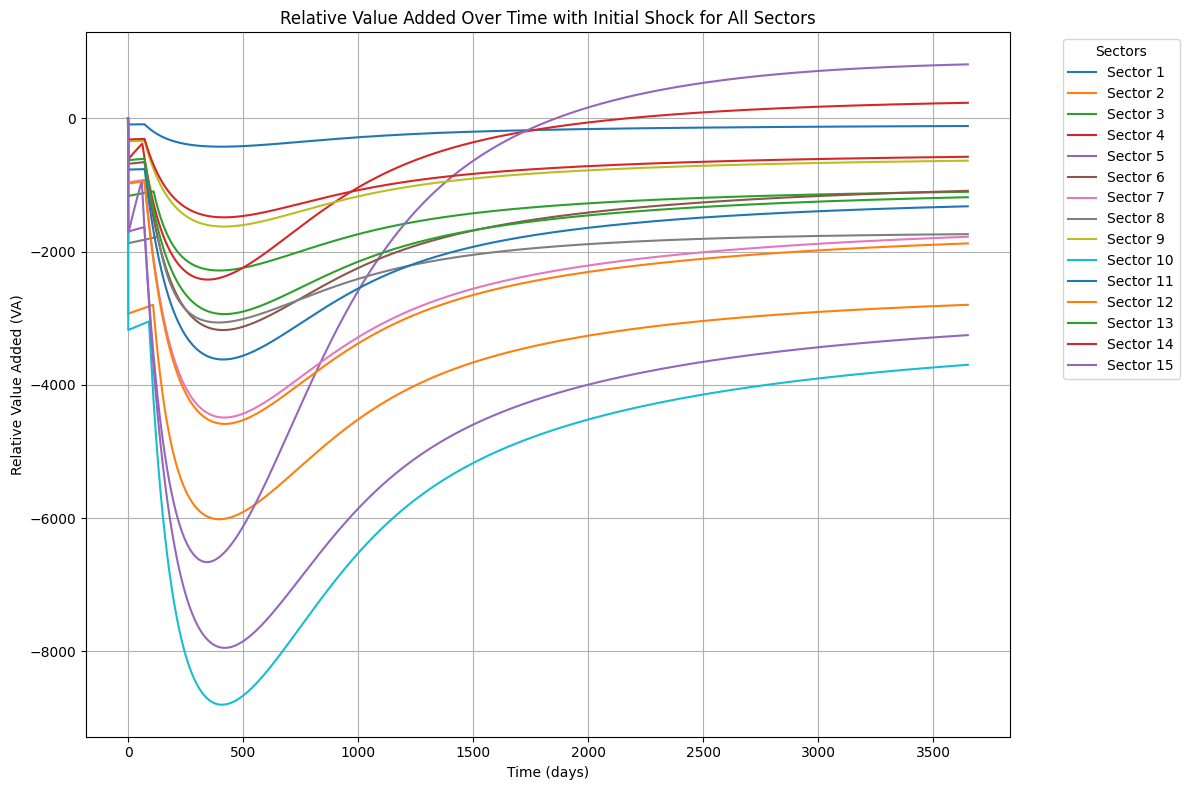

In [19]:
import matplotlib.pyplot as plt
# Plot the time series for all sectors
plt.figure(figsize=(12, 8))
for i in range(15):
    plt.plot(range(Res_VA.shape[0]), np.array([i - i[0] for i in Res_VA.T]).T[:, i], label=f"Sector {i+1}")
plt.xlabel("Time (days)")
plt.ylabel("Relative Value Added (VA)")
plt.title("Relative Value Added Over Time with Initial Shock for All Sectors")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Sectors")
plt.grid()
plt.tight_layout()
plt.show()